# EDS2CHEM Example script

This takes one PC map from QEMSCAN data and calibrates the PC map with EPMA profiles.

In [2]:
import os
import numpy as np
import pandas as pd
#own code:
from GPyEDS.EDS2CHEM import mcmc
import GPyEDS
from GPyEDS import utils

def calc_an(CaO, Na2O):
    return ((CaO/56.0774)/(CaO/56.0774+2*Na2O/61.9789))*100

## Load Data

In [3]:
import pickle

with open("../../QEMSCAN/GPAM/PCA/all_qemscan_dict.pkl", "rb") as f:
    r = pickle.load(f)["0501_2_extra"]["plag"]

In [4]:
gauss_plag_pca = utils.gaussian_filter(utils.get_img(r[0][:,0], r[1]), r[1], std = 1)

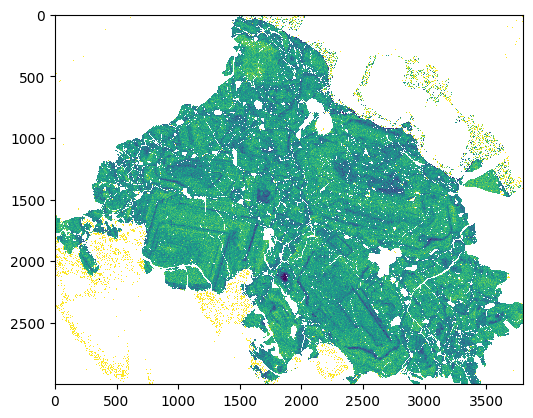

In [5]:
import matplotlib.pyplot as plt
plt.imshow(gauss_plag_pca, interpolation = "none", vmin = 0, vmax =50)

## Run MCMC calibration

In reality this needs running for longer - this is just as an indication

In [6]:
import chardet
##############################################
##############################################
plag_crysts = ['Sample501_2_c2r_plag1', 'Sample501_2_r2c_plag2', 'Sample501_2_plag3']
regions = [[1500,1800, 3000,3400],[1700,2000, 1400,1800],[1500,1900, 950,1250]]
params_list = [[100., 225., 120., 140.,  5., 1., 1., 90.], [145., 240., 150., 175.,  5., 1., 1., 90.], [200.,175. ,250.,150.,  5., 1., 1., 90.]]
##############################################
##############################################


import chardet
with open("Sample501_2_0_oxide.txt", 'rb') as f:
    result = chardet.detect(f.read()) 

DF_NEW = pd.read_csv("Sample501_2_0_oxide.txt", skiprows=[i for i in range(51)], delimiter = "\t",
                          encoding = result['encoding'], index_col= ['Comment', 'DataSet/Point'],)

samplename = DF_NEW.index.levels[0]



DF_NEW["Anorthite"] = calc_an(DF_NEW["CaO"].to_numpy(), DF_NEW["Na2O"].to_numpy())




for i in range(3):
    if i == 0:
        continue
    if i == 2:
        continue
    region = regions[i]
    xl_pca1 = gauss_plag_pca[region[0]:region[1], region[2]:region[3]]

    k8_plag1 = DF_NEW.loc[plag_crysts[i]]

    plag1 = k8_plag1

    indparams_1 = [xl_pca1, plag1]

    # MCMC parameter setup -- a x and y coordinates (left point), b x and y coordinates (right point), window width, slope, intercept
    # pnames   = ["ax","ay", "bx", "by", "ww", "m", "b"]
    # change step sizes to better suit the ranges

    params1 = np.asarray(params_list[i])
    

    # minimum and maximum parameter values 
    parameter_delta = [50.,50.,50.,50.]
    pmin1 =   np.array([params1[0] - parameter_delta[0] ,params1[1] - parameter_delta[1],params1[2] - parameter_delta[2],
                        params1[3] - parameter_delta[3],  1., -100., -100., 0.0])
    pmax1 =   np.array([params1[0] + parameter_delta[0] ,params1[1] + parameter_delta[1],params1[2] + parameter_delta[2],
                        params1[3] + parameter_delta[3],    30., 0., 100., 180.0])
    files = plag_crysts[i]
    an_1 = plag1.Anorthite.values / 100

    mc3_output1 = mcmc.MCMC_run(xl_pca1, an_1, an_1*0.01, params = params1,
                    pmin = pmin1, pmax = pmax1, positions = np.linspace(0,len(an_1)-1, len(an_1)).astype("int64"), num_iter=10000, return_ = True, name = plag_crysts[i])
    
    samples = mc3_output1.get_chain(discard=1000, thin = 18, flat = True)
    
    np.save("july24_emcee_flat_samples_plag_" + str(i+1) + ".npy", samples)

[ 1.44962774e+02  2.40214989e+02  1.50069457e+02  1.75128614e+02
  5.11059881e+00 -3.56066151e-03  7.74719524e-01  9.00598824e+01]


100%|██████████| 10000/10000 [27:44<00:00,  6.01it/s]


## Inspect parameter space

This is corner plot of posterior distribution

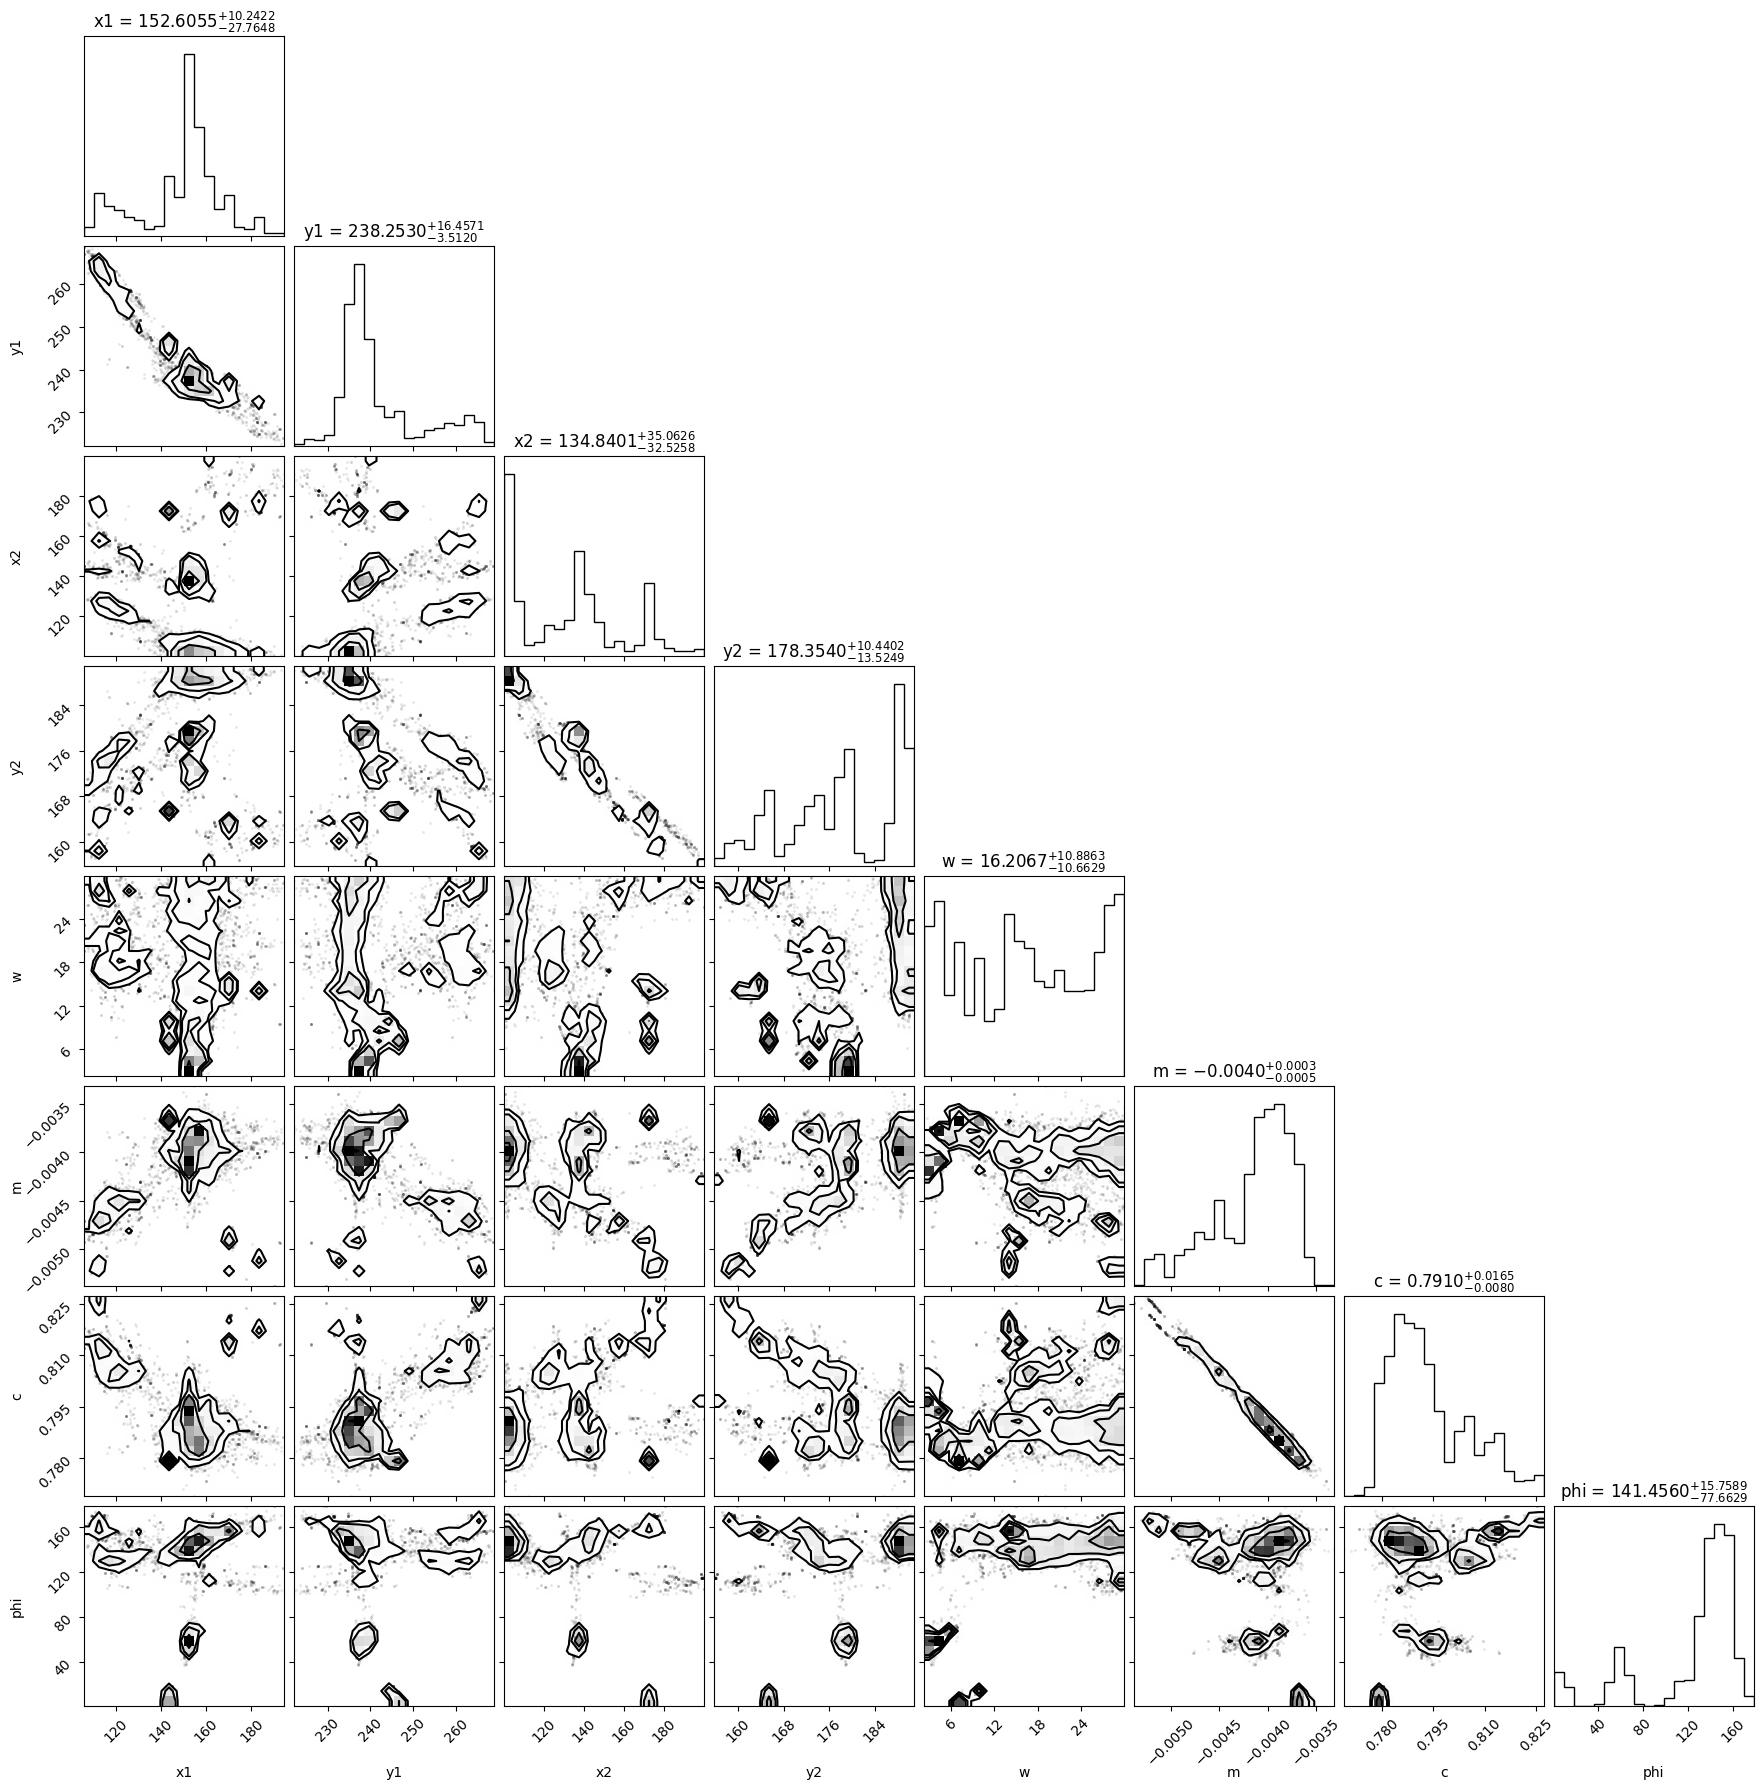

In [10]:
import corner
figure = corner.corner(samples, labels = ["x1","y1", "x2", "y2", "w", "m", "c", "phi"], show_titles=True, title_fmt=".4f")

In [8]:
np.mean(samples,axis = 0)

array([ 1.49604421e+02,  2.41420276e+02,  1.31688738e+02,  1.77816665e+02,
        1.59245302e+01, -4.12418902e-03,  7.93087004e-01,  1.25096418e+02])

## Visualise results

calibration curve:

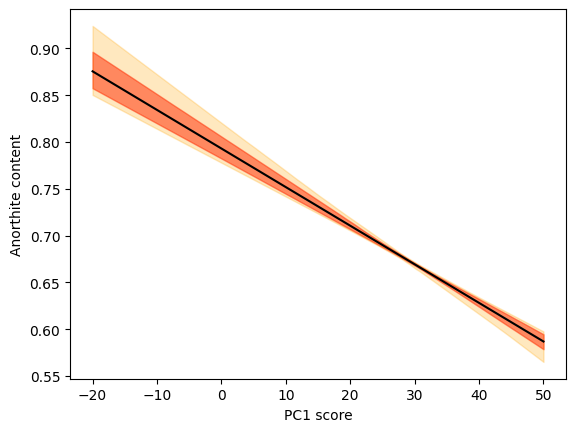

In [15]:
xdata = np.linspace(-20, 50, 250)
ysamples = [xdata[i]*samples[:,5] + samples[:,6] for i in range(len(xdata))]
ye1 = np.quantile(np.sort(ysamples, axis = 0), 0.16, axis = 1)
ye2 = np.quantile(np.sort(ysamples, axis = 0), 0.84, axis = 1)
ye3 = np.quantile(np.sort(ysamples, axis = 0), 0.025, axis = 1)
ye4 = np.quantile(np.sort(ysamples, axis = 0), 0.975, axis = 1)
plt.plot(xdata,np.mean(ysamples, axis = 1), 'k-')
plt.fill_between(xdata[::-1], ye2, ye1, alpha = 0.5, color = 'r', label = "+/- 1 SD")
plt.fill_between(xdata[::-1], ye4, ye3, alpha = 0.25, color = 'orange', label = "+/- 2 SD")
plt.ylabel("Anorthite content")
plt.xlabel("PC1 score")
plt.savefig("plag2_calibration_fig.png", dpi = 300)

In [19]:
from MCMC_emcee import align
model_res = []
for item in samples[::10,:]:
    model = align(xl_pca1, len(an_1), item)
    model_res.append(model)
model_res = np.asarray(model_res)

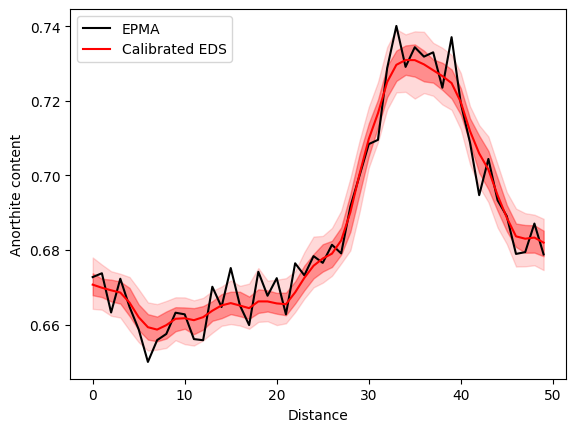

In [20]:
yes1 = []
yes2 = []
yes3 = []
yes4 = []
for i in range(model_res.shape[1]):
    yes1.append(np.quantile(np.sort(model_res[:,i]), 0.16))
    yes2.append(np.quantile(np.sort(model_res[:,i]), 0.84))
    yes3.append(np.quantile(np.sort(model_res[:,i]), 0.025))
    yes4.append(np.quantile(np.sort(model_res[:,i]), 0.975))

plt.plot(range(len(an_1)), an_1, 'k', label = "EPMA")
plt.plot(range(len(model)), np.mean(model_res, axis = 0), 'r', label = "Calibrated EDS")
plt.fill_between(range(len(model)), yes1, yes2, color = 'r', alpha = 0.35,)
plt.fill_between(range(len(model)), yes3, yes4, color = 'r', alpha = 0.15)
plt.ylabel("Anorthite content")
plt.xlabel("Distance")
plt.legend()
#plt.savefig("EDS2CHEM_0424_plag2_wPhi_emcee_example.png", dpi = 300)

Text(0.5, 0, 'Distance')

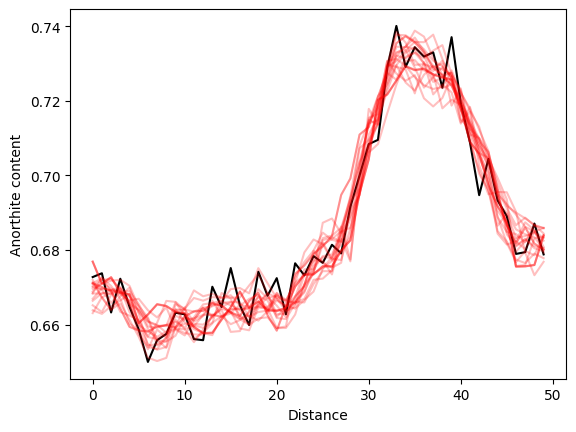

In [21]:
import matplotlib.pyplot as plt
plt.plot(range(len(an_1)), an_1, 'k', label = "EPMA")
inds = np.random.randint(0, 463, 20)
for _ in range(20):
    plt.plot(range(len(model)), model_res[inds[_],:], 'r', label = "Calibrated EDS", alpha = 0.25)

plt.ylabel("Anorthite content")
plt.xlabel("Distance")
#plt.savefig("plag2_samples.png", dpi = 300)

Possible locations:

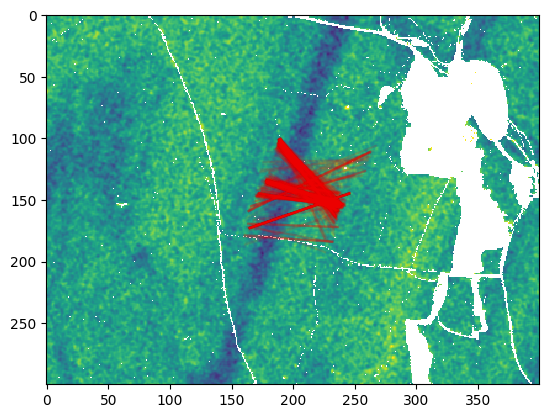

In [28]:
plt.imshow(xl_pca1, interpolation="None", vmin = 0, vmax = 50)
#plt.colorbar()
inds = np.random.randint(0, 4600, 1000)
for _ in range(1000):
    item = samples[inds[_]]
    plt.plot([item[1], item[3]], [item[0], item[2]], 'r-', alpha = 0.05)
#plt.savefig("plag2_map_w_samples.png", dpi = 300)